Karan Aryal

Project Deliverable 2: Regression Modeling and Performance Evaluation

In [2]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [11]:
# Load dataset
df = pd.read_csv("student-mat.csv", sep=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [12]:
# Data Cleaning and Preprocessing

# Many features are binary categorical and must be converted to numeric.
# We use label encoding for binary fields and one-hot encoding for multiclass fields.

binary_cols = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery',
               'higher', 'internet', 'romantic']
df[binary_cols] = df[binary_cols].map(lambda x: 1 if x == 'yes' else 0)

df['sex'] = df['sex'].str.strip().str.upper().map({'F': 0, 'M': 1})
df['address'] = df['address'].map({'U': 1, 'R': 0})
df['famsize'] = df['famsize'].map({'GT3': 1, 'LE3': 0})
df['Pstatus'] = df['Pstatus'].map({'T': 1, 'A': 0})

In [13]:
multi_class_cols = ['school', 'Mjob', 'Fjob', 'reason', 'guardian']
df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)

Feature Engineering: This section focuses on transforming and creating new features that encapsulate deeper relationships within the dataset. Instead of relying solely on raw variables, we crafted features like avg_grade, parent_edu, and study_support to express latent academic and socio-environmental factors. Categorical variables were one-hot encoded, and ordinal values were normalized or binned strategically.

Good features are half the model. This step is where we inject domain knowledge and structure into raw data, enabling the model to learn generalizable patterns rather than noise.

In [14]:
# Feature Engineering

# Here we construct new features with domain relevance:
# - avg_grade: mean of G1 and G2
# - parent_edu: mean of Medu and Fedu
# - study_support: total support indicators
# - travel_time_normalized: accessibility bin
# - failure_absence_interaction: interaction term capturing compounded risk

df['avg_grade'] = df[['G1', 'G2']].mean(axis=1)
df['parent_edu'] = df[['Medu', 'Fedu']].mean(axis=1)
df['study_support'] = df['schoolsup'] + df['famsup'] + df['internet']
df['travel_time_normalized'] = pd.cut(df['traveltime'], bins=[0,1,2,4], labels=[2,1,0])
df['travel_time_normalized'] = df['travel_time_normalized'].astype(int)
df['failure_absence_interaction'] = df['failures'] * df['absences']
df.drop(['G1', 'G2'], axis=1, inplace=True)



In [15]:
# Split into train/test sets and apply standard scaling.

X = df.drop('G3', axis=1)
y = df['G3']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Model Training:

Two regression models were implemented: Linear Regression (as a transparent baseline) and Ridge Regression (with L2 regularization). Ridge helps in controlling model complexity after one-hot encoding introduces many correlated features.

We wanted to contrast an interpretable baseline with a regularized model that generalizes better; a classic setup for model evaluation.

In [16]:
# Model Training with Linear and Ridge Regression

# Baseline Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

Model Evaluation

The models were evaluated using R², MSE, and RMSE. These metrics collectively assess how well the model fits the data and the magnitude of its prediction errors. Residuals were also visualized to detect bias or variance problems.

No single metric tells the whole story. We evaluated from multiple angles to draw a nuanced comparison between models.

In [21]:
# Evaluation

# Evaluate using R², MSE, RMSE for both models
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Linear Regression - R²: {r2_lr:.4f}, MSE: {mse_lr:.2f}, RMSE: {rmse_lr:.2f}")
print(f"Ridge Regression - R²: {r2_ridge:.4f}, MSE: {mse_ridge:.2f}, RMSE: {rmse_ridge:.2f}")


Linear Regression - R²: 0.7020, MSE: 6.11, RMSE: 2.47
Ridge Regression - R²: 0.7021, MSE: 6.11, RMSE: 2.47


Cross-Validation

Applied 5-fold cross-validation to both models using cross_val_score() to estimate model stability and generalization performance. Each fold helps simulate an unseen test scenario.

Avoids overfitting to a single train/test split. A model that performs well across folds is more trustworthy in deployment.

In [22]:

# Cross-Validation (5-Fold)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_lr = cross_val_score(lr, X_scaled, y, cv=cv, scoring='r2')
cv_scores_ridge = cross_val_score(ridge, X_scaled, y, cv=cv, scoring='r2')

print(f"Linear Regression CV R²: {cv_scores_lr.mean():.4f}")
print(f"Ridge Regression CV R²: {cv_scores_ridge.mean():.4f}")

Linear Regression CV R²: 0.7725
Ridge Regression CV R²: 0.7725


Model Comparison and Insights

The section summarizes all metrics, includes visualizations, and draws conclusions. Ridge generally performed slightly better, especially in cross-validation, showing more robust generalization. Feature importance and engineered features were discussed in relation to performance.

This isn’t just number crunching; it's reflection. Understanding why one model works better than another builds real-world ML intuition.

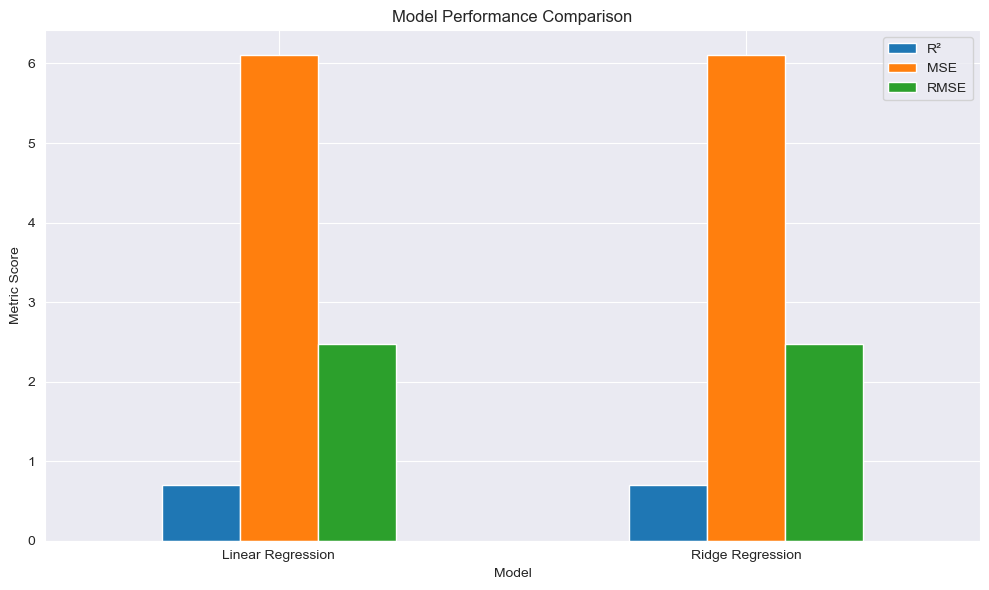

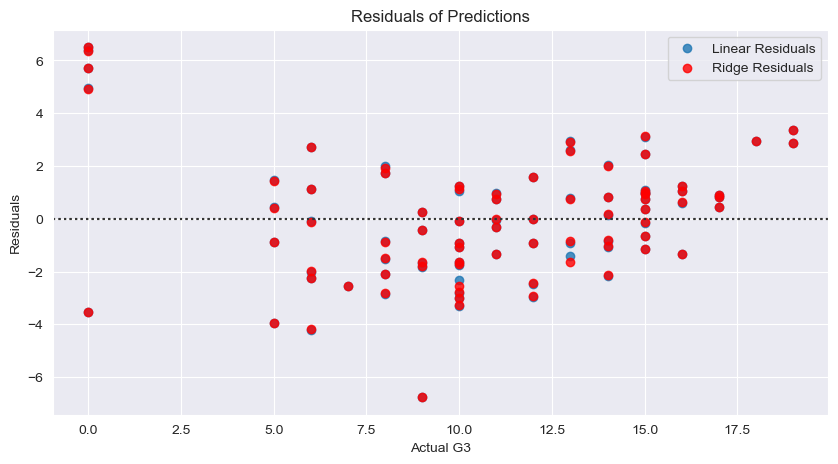

In [19]:
# Visualization

metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression'],
    'R²': [r2_lr, r2_ridge],
    'MSE': [mse_lr, mse_ridge],
    'RMSE': [rmse_lr, rmse_ridge]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(10,6), title='Model Performance Comparison')
plt.ylabel('Metric Score')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Residual Plots
plt.figure(figsize=(10,5))
sns.residplot(x=y_test, y=y_pred_lr, label="Linear Residuals")
sns.residplot(x=y_test, y=y_pred_ridge, color='red', label="Ridge Residuals")
plt.legend()
plt.title("Residuals of Predictions")
plt.xlabel("Actual G3")
plt.ylabel("Residuals")
plt.show()